In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [6]:
df = pd.read_csv('../data/final/final_df.csv')

In [ ]:
df['label'] = df['label'].map({1:"HATE", 0:"NON_HATE"})


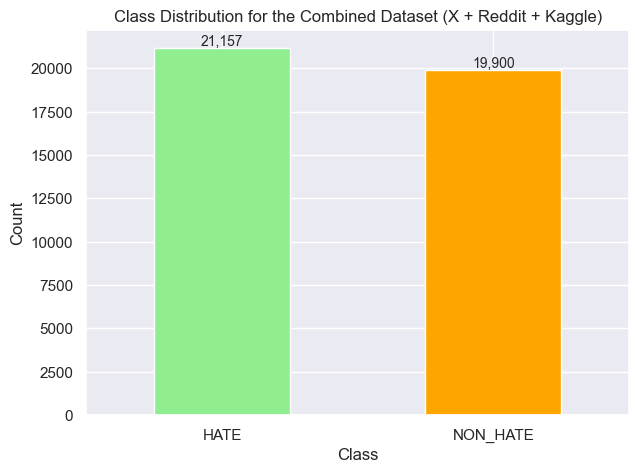

In [12]:
class_count = df['label'].value_counts()
plt.figure(figsize=(7,5))
bars = class_count.plot(kind='bar', color=['lightgreen','orange'])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
    
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution for the Combined Dataset (X + Reddit + Kaggle)")
plt.xticks(rotation=0)
plt.show()

In [ ]:
df['label'] = df['label'].map({"HATE":1, "NON_HATE":0})

,processed_text,source,label
0,pamela anderson article joy stall want enterta...,kaggle,0
1,know signed law effect trump trump signed law ...,reddit,1
2,not saying saying mean harm not lesbian femini...,reddit,0
3,far right party never actually solve immigrati...,reddit,0
4,interesting actually not seen many people labe...,reddit,0
...,...,...,...
41052,lesbian bar random wednesday thursday lady nig...,reddit,0
41053,equal not better,reddit,0
41054,hoping wikipedia not biased,kaggle,1
41055,thou wilt walk david thy father walked integri...,x,0


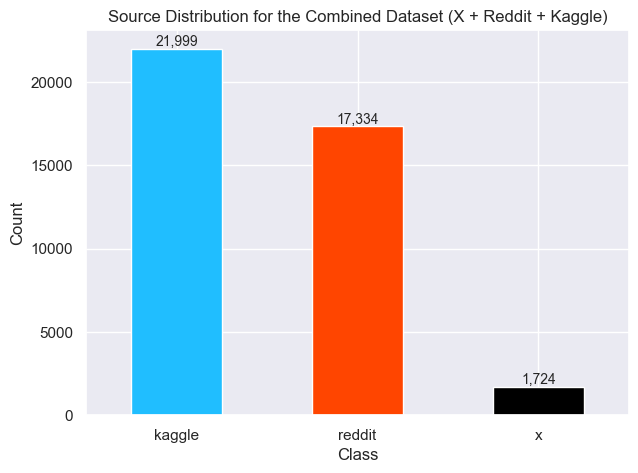

In [21]:
class_count = df['source'].value_counts()
plt.figure(figsize=(7,5))
bars = class_count.plot(kind='bar', color=['#20beff','#FF4500','black'])

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, 
             bar.get_height(), 
             f"{bar.get_height():,}",
             ha="center", va="bottom", fontsize=10)
    
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Source Distribution for the Combined Dataset (X + Reddit + Kaggle)")
plt.xticks(rotation=0)
plt.show()

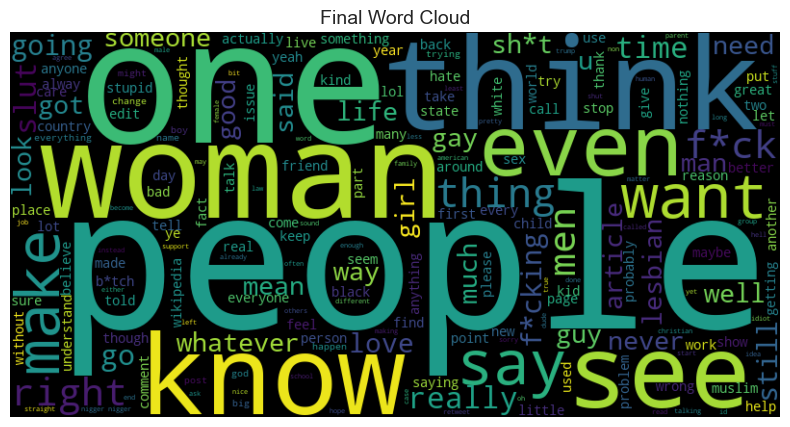

In [23]:
from wordcloud import WordCloud
import re

def censor_words(text, banned_words):
    def censor_match(match):
        word = match.group(0)
        censored_word = re.sub(r'([aeiouAEIOU])', '*', word, count=1)
        return censored_word

    pattern = r"\b(" + "|".join(re.escape(word) for word in banned_words) + r")\b"
    return re.sub(pattern, censor_match, text, flags=re.IGNORECASE)


text_data = " ".join(df["processed_text"].astype(str))
banned_words = {"fuck", "fucking", "shit", "bitch", "faggot", "nigga"}

censored_text = censor_words(text_data, banned_words)

wordcloud = WordCloud(
    width=800, height=400,
    background_color="black",
    colormap="viridis",
    max_words=200,  
    regexp=r"\b[a-zA-Z*]+\b" 
).generate(censored_text)


plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Final Word Cloud", fontsize=14)
plt.show()